In [1]:
import pandas as pd
import requests
import bs4
from typing import List, Dict
import numpy as np


# fbref.com

Get match urls

In [2]:
def get_team_matches(team_id, season:str)->List[Dict[str, str|bool]]:
    fbref_url = f'https://fbref.com/en/squads/{team_id}/{season}/all_comps/'
    fb_ref = requests.get(fbref_url)
    soup = bs4.BeautifulSoup(fb_ref.text)
    tables = soup.find_all("table")
    match_table = tables[5]
    match_links = [t['href'] for t in match_table.find_all("a") if '/en/matches/' in t['href']]

    matches =[]

    for idx, rw in enumerate(match_table.find_all("tr")):
        try:
            match_date = rw.find("th").text
            competition = rw.find("td",{"data-stat":"comp"}).text
            home = rw.find("td",{"data-stat":"venue"}).text =='Home'
            opponent = rw.find("td",{"data-stat":"opponent"}).text
            try:
                link = rw.find("th").find("a")['href']
            except TypeError:
                link = None
            match = {"date":match_date, "competition":competition, 
                        "is_home":home, "opponent":opponent, "link":link }
            matches.append(match)
        except AttributeError:
            continue
    return matches

Get match lineups

In [3]:
def get_match_lineups(match_id:str)->(List[str],List[str]):
    fbref_url = 'https://fbref.com/en/matches/' + match_id
    fb_ref = requests.get(fbref_url)
    soup = bs4.BeautifulSoup(fb_ref.text)
    tables = soup.find_all("table")

    df = pd.read_html(str(tables[0]))[0]
    bench_idx = df[df.iloc[:,0]=='Bench'].index[0]
    bench_lineup = df.loc[bench_idx+1:, :]
    starting_lineup = df.loc[:bench_idx-1:, :]
    starting_lineup = starting_lineup.iloc[:,1]
    bench_lineup = bench_lineup.iloc[:,1]
    return [*starting_lineup], [*bench_lineup]

In [4]:
def get_player_matches(player_id:str, season:str)->pd.DataFrame:
    """season should be in format like: '2022-2023'"""
    fbref_url = f"https://fbref.com/en/players/{player_id}/matchlogs/{season}/"
    fb_ref = requests.get(fbref_url)
    soup = bs4.BeautifulSoup(fb_ref.text)
    tables = soup.find_all("table")

    df = pd.read_html(str(tables[0]))[0]
    df= df.droplevel(0, axis=1)
    df['Min'] = df['Min'].replace("On matchday squad, but did not play", 0)
    df.dropna(axis=0, inplace=True)
    df.replace("On matchday squad, but did not play", None, inplace=True)
    keep_cols = ['Date', 'Comp', 'Squad', 'Opponent',
        'Start', 'Min']
    return df[keep_cols]


In [5]:
def get_playing_time(team_id, player_id, season):
    liverpool_matches = get_team_matches(team_id, season)
    player_matches = get_player_matches(player_id,season)
    player_games_df = pd.DataFrame(liverpool_matches).merge(player_matches, left_on='date', right_on='Date', how='left')

    # games without a link haven't been played yet (postponed or future date)
    player_games_df.dropna(subset=['link'], inplace=True)
    player_games_df.drop('Date', inplace=True, axis=1)

    return player_games_df

In [6]:
liverpool_id = '822bd0ba'
konate_id = "5ed9b537"

konate_playing_time2223 = get_playing_time(liverpool_id, konate_id, '2022-2023')
konate_playing_time2122 = get_playing_time(liverpool_id, konate_id, '2021-2022')
konate_all_liverpool_df = pd.concat([konate_playing_time2122,konate_playing_time2223])
konate_all_liverpool_df['date'] = pd.to_datetime(konate_all_liverpool_df['date'])


def get_squad_status(is_start:str):
    start_map = {"Y":"Start", "N": "Bench", np.nan:"Not in Squad"}
    return start_map[is_start]
    
konate_all_liverpool_df['Start'] = konate_all_liverpool_df['Start'].apply(get_squad_status)
konate_all_liverpool_df.fillna(0, inplace=True)

konate_all_liverpool_df.head()

,date,competition,is_home,opponent,link,Comp,Squad,Opponent,Start,Min
0,2021-08-14,Premier League,False,Norwich City,/en/matches/c52500ad/Norwich-City-Liverpool-Au...,Premier League,Liverpool,Norwich City,Bench,0
1,2021-08-21,Premier League,True,Burnley,/en/matches/94d9dac0/Liverpool-Burnley-August-...,Premier League,Liverpool,Burnley,Bench,0
2,2021-08-28,Premier League,True,Chelsea,/en/matches/78aa75e6/Liverpool-Chelsea-August-...,Premier League,Liverpool,Chelsea,Bench,0
3,2021-09-12,Premier League,False,Leeds United,/en/matches/e6a245be/Leeds-United-Liverpool-Se...,Premier League,Liverpool,Leeds United,Bench,0
4,2021-09-15,Champions Lg,True,it Milan,/en/matches/ff3e4ae2/Liverpool-Milan-September...,Champions Lg,eng Liverpool,it Milan,Bench,0


In [7]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

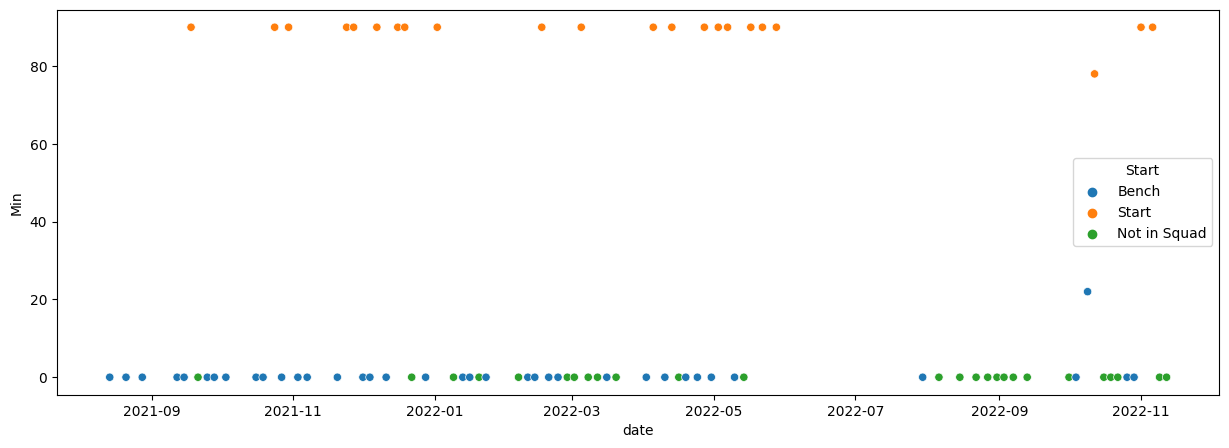

In [8]:

fig,ax = plt.subplots(figsize=(15,5))
konate_plot_data = konate_all_liverpool_df[['date', 'Min', 'Start']].set_index('date')
konate_plot_data['Min'] = pd.to_numeric(konate_plot_data['Min'])
_ = sns.scatterplot(konate_plot_data, ax=ax, x= 'date', y='Min', hue='Start')

We want to overlay injury data so we can see reasons why Konate wasn't in the squad
- this can't be found on fbref.com so we'll have to scrape another data source

transfermarkt.com has all the data we need - we could've skipped the fbref stuff above :)

![tm data](./transfrmarkt-data.png)

In [9]:
headers ={
    "sec-ch-ua": '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
    "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"
}
tm_res = requests.get(url = "https://www.transfermarkt.com/ibrahima-konate/leistungsdaten/spieler/357119/saison/2022/plus/1", headers=headers)
dfs = pd.read_html(tm_res.content)
match_dfs =[]
for idx,df in enumerate(dfs):
    if 'Matchday' in df.columns:
        match_dfs.append(df)
all_matches = pd.concat(match_dfs)
all_matches = all_matches.loc[all_matches.iloc[:,0].apply(lambda x:'Squad' not in x)]
all_matches['Date'] = pd.to_datetime(all_matches['Date'])
all_matches.head()

,Matchday,Date,Home team,Home team.1,Away team,Away team.1,Result,Pos.,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Group A,2022-09-07,NaN,SSC Napoli,NaN,Liverpool,4:1,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury
1,Group A,2022-09-13,NaN,Liverpool,NaN,Ajax,2:1,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury,Knee Injury
2,Group A,2022-10-04,NaN,Liverpool,NaN,Rangers,2:0,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench
3,Group A,2022-10-12,NaN,Rangers,NaN,Liverpool,1:7,CB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79',79',NaN
4,Group A,2022-10-26,NaN,Ajax,NaN,Liverpool,0:3,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench,on the bench


In [10]:
all_matches['min_played'] = all_matches.iloc[:,16]
all_matches['subbed_off'] = all_matches.iloc[:,15]
all_matches['subbed_on'] = all_matches.iloc[:,14]
all_matches.dropna(axis=1, how='all', inplace=True)
all_matches = all_matches[['Date', 'Home team.1','Away team.1', 'Result','min_played','subbed_on', 'subbed_off']]
all_matches.head()

,Date,Home team.1,Away team.1,Result,min_played,subbed_on,subbed_off
0,2022-09-07,SSC Napoli,Liverpool,4:1,Knee Injury,Knee Injury,Knee Injury
1,2022-09-13,Liverpool,Ajax,2:1,Knee Injury,Knee Injury,Knee Injury
2,2022-10-04,Liverpool,Rangers,2:0,on the bench,on the bench,on the bench
3,2022-10-12,Rangers,Liverpool,1:7,79',NaN,79'
4,2022-10-26,Ajax,Liverpool,0:3,on the bench,on the bench,on the bench


Separate out columns for minutes played and availability status - i.e. injured, on bench etc

In [11]:
def get_availability(row:pd.Series):
    if row['min_played']>0:
        if row['subbed_on'] is np.nan:
            return "Played (starter)"
        return "Played (sub)"
    if row['subbed_on'] =='on the bench':
        return "Bench"
    if row['subbed_on'] == 'Not in squad':
        return 'Not in squad'
    return "Injured"
    
def get_min_played(min_played:str):
    minutes_split = min_played.split("'")
    if len(minutes_split)<2:
        return 0
    else:
        return int(minutes_split[0])
all_matches['min_played'] = all_matches['min_played'].apply(get_min_played)

# create categories based on subbed on/off, minutes played
all_matches['availability'] = all_matches.apply(get_availability, axis=1)
all_matches.head()

,Date,Home team.1,Away team.1,Result,min_played,subbed_on,subbed_off,availability
0,2022-09-07,SSC Napoli,Liverpool,4:1,0,Knee Injury,Knee Injury,Injured
1,2022-09-13,Liverpool,Ajax,2:1,0,Knee Injury,Knee Injury,Injured
2,2022-10-04,Liverpool,Rangers,2:0,0,on the bench,on the bench,Bench
3,2022-10-12,Rangers,Liverpool,1:7,79,NaN,79',Played (starter)
4,2022-10-26,Ajax,Liverpool,0:3,0,on the bench,on the bench,Bench


In [12]:
all_matches[all_matches['Date']=='2022-03-08']

,Date,Home team.1,Away team.1,Result,min_played,subbed_on,subbed_off,availability


We can now do the same plot as before

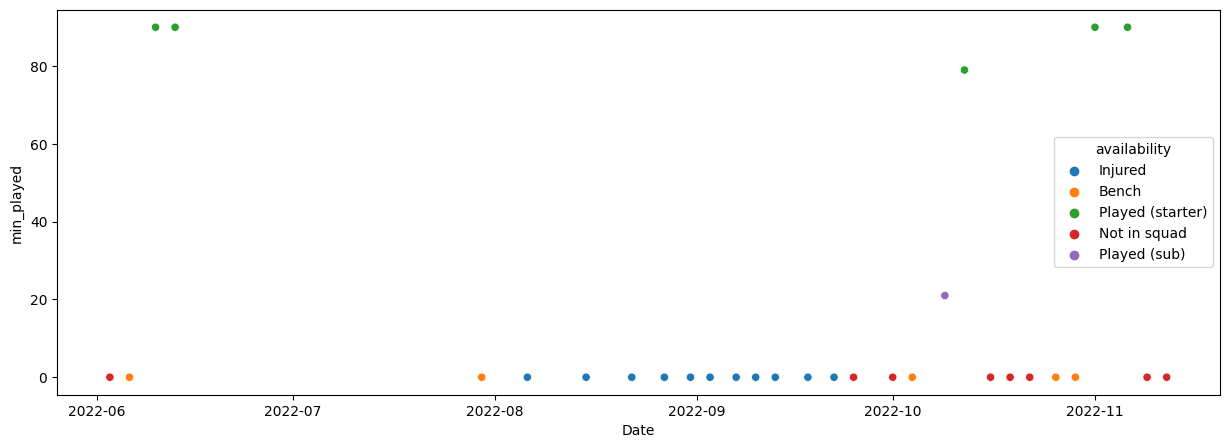

In [13]:
fig,ax = plt.subplots(figsize=(15,5))

plot = sns.scatterplot(all_matches, ax=ax, x= 'Date', y='min_played', hue='availability')

This visual doesn't capture the differences between availability levels very well - the emphasis is too much on the minutes played and there is too much white space since its rare to get intermediate values of minutes played - you either play the majority of the game or you don't. 

Let's change the availability into numeric levels and reshape the data so we can plot as a heatmap

In [14]:
availability_levels_map = {
                        'Injured':0, 
                        'Not in squad':1,
                        'Bench':2, 
                        'Played (sub)':3,
                        'Played (starter)':4 
                        }
all_matches['availability_level'] = all_matches['availability'].map(availability_levels_map)
all_matches.head()
availability_df = all_matches.loc[:,['Date','availability_level']]
availability_df.sort_values('Date', inplace=True)
availability_df['Date'] = availability_df['Date'].apply(lambda x:x.date())
availability_df = availability_df.set_index('Date').transpose()
availability_df.rename({"availability_level":"konate"},axis=0, inplace=True)

This looks more like what I was thinking of - we can now add in more "rows" to the heatmaps for other players to build up a better picture of overall availability

In [15]:
len(all_matches['availability'].unique())


5

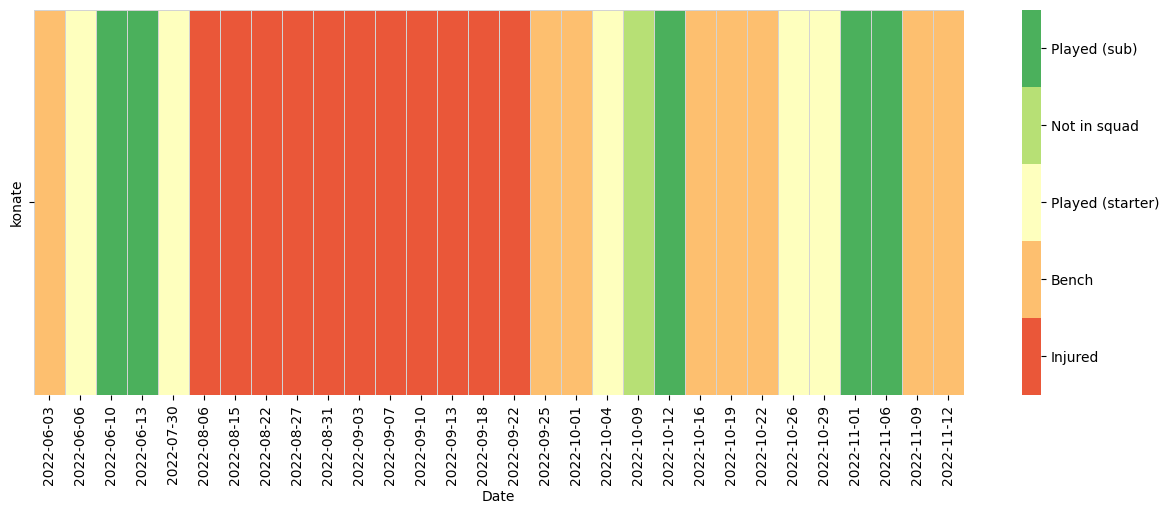

In [16]:
fig,ax = plt.subplots(figsize=(15,5))
availability_levels = all_matches['availability'].unique()
num_levels = len(availability_levels)

plot = sns.heatmap(availability_df, ax=ax, cmap=sns.color_palette("RdYlGn", n_colors=num_levels),linewidths=.5, linecolor='lightgray')
colorbar = plot.collections[0].colorbar
total_bar_height = colorbar.vmax - colorbar.vmin 
lvl_bar_height = total_bar_height/num_levels

colorbar.set_ticks([colorbar.vmin + (lvl_bar_height * (0.5 + i)) for i in range(num_levels)])
colorbar.set_ticklabels([*availability_levels])


Next step: refactor steps above into functions so we can generate the data for other players, teams and time periods to make these plots in a reliable and repeatable way.

Need an easy way to get ids of players so we know which url to go to for stats

In [144]:
from typing import Optional
def get_prem_club_list(season:str='2022')->Dict[str,str]:
    headers ={
    "sec-ch-ua": '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
    "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"
    }
    prem_teams_res = requests.get(url = f"https://www.transfermarkt.com/premier-league/startseite/wettbewerb/GB1?saison_id={season}", headers=headers)
    prem_teams_dfs = pd.read_html(prem_teams_res.text, extract_links="all")
    return {i[0]:i[1] for i in prem_teams_dfs[1].iloc[:,1] if i[1] is not None}

In [18]:

def get_player_list(team_url:str)->Dict[str,str]:
    """
    get profile links of players at team_name
    returns {'player_name':'player_url'}
    """
    headers ={
    "sec-ch-ua": '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
    "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"
    }
    team_res = requests.get(url ="https://www.transfermarkt.com" + team_url, headers=headers)
    soup = bs4.BeautifulSoup(team_res.text)
    players = {link for link in soup.select("tr .posrela a") if link.get('title') ==link.contents[0]}
    return {player.contents[0]:player['href'] for player in players} 

In [271]:

def get_player_availability(player_profile_url:str):
    # get name out of url
    player_name = player_profile_url.split("https://www.transfermarkt.com/")[1].split("/")[0]
    # stats for injuries are on different page to profile
    player_url = player_profile_url.replace("profil", "leistungsdatendetails")
    headers ={
        "sec-ch-ua": '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
        "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"
    }
    tm_res = requests.get(url = player_url, headers=headers)
    dfs = pd.read_html(tm_res.text)
    match_dfs =[]
    for idx,df in enumerate(dfs):
        if 'Matchday' in df.columns:
            match_dfs.append(df)
    all_matches = pd.concat(match_dfs)
    all_matches = all_matches.loc[all_matches.iloc[:,0].apply(lambda x:'Squad' not in str(x))]
    all_matches['Date'] = pd.to_datetime(all_matches['Date'])

    # last column is minutes played
    all_matches['min_played'] = all_matches.iloc[:,16]
    all_matches['subbed_off'] = all_matches.iloc[:,15]
    all_matches['subbed_on'] = all_matches.iloc[:,14]
    all_matches.dropna(axis=1, how='all', inplace=True)
    all_matches = all_matches[['Date', 'Home team.1','Away team.1', 'Result','min_played','subbed_on', 'subbed_off']]

    def get_availability(row:pd.Series):
        if row['min_played']>0:
            if row['subbed_on'] is np.nan:
                return "Played (starter)"
            return "Played (sub)"
        if row['subbed_on'] =='on the bench':
            return "Bench"
        if row['subbed_on'] == 'Not in squad':
            return 'Not in squad'
        if 'suspension' in str(row['subbed_on']).lower():
            return 'Suspended'
        
        return 'Injured'
        
    def get_min_played(min_played:str):
        minutes_split = str(min_played).split("'")
        if len(minutes_split)<2:
            return 0
        else:
            return int(minutes_split[0])
    all_matches['min_played'] = all_matches['min_played'].apply(get_min_played)

    # create categories based on subbed on/off, minutes played
    all_matches['availability'] = all_matches.apply(get_availability, axis=1)

    availability_levels = {
                            'Injured':0, 
                            'Not in squad':1,
                            'Bench':2, 
                            'Played (sub)':3,
                            'Played (starter)':4 
                            }
    all_matches['availability_level'] = all_matches['availability'].map(availability_levels)
    all_matches.head()
    availability_df = all_matches.loc[:,['Date','availability_level']]
    availability_df.sort_values('Date', inplace=True)
    availability_df['Date'] = availability_df['Date'].apply(lambda x:x.date())
    availability_df = availability_df.set_index('Date').transpose()
    availability_df.rename({"availability_level":player_name},axis=0, inplace=True)

    return availability_df

## Aug 2021 - Present (2022) Analysis 

In [20]:
lpool_url = get_prem_club_list()['Liverpool FC']
lpool_players = get_player_list(lpool_url)
lpool_players.keys()

dict_keys(['Nathaniel Phillips', 'Harvey Elliott', 'James Milner', 'Naby Keïta', 'Mohamed Salah', 'Fábio Carvalho', 'Calvin Ramsay', 'Thiago', 'Trent Alexander-Arnold', 'Jordan Henderson', 'Andrew Robertson', 'Roberto Firmino', 'Curtis Jones', 'Joe Gomez', 'Alisson', 'Darwin Núñez', 'Arthur Melo', 'Diogo Jota', 'Ibrahima Konaté', 'Caoimhín Kelleher', 'Adrián', 'Joel Matip', 'Fabinho', 'Konstantinos Tsimikas', 'Virgil van Dijk', 'Alex Oxlade-Chamberlain', 'Luis Díaz'])

In [21]:
matip_url = "https://www.transfermarkt.com" + lpool_players['Joel Matip'] 
konate_url = "https://www.transfermarkt.com" + lpool_players['Ibrahima Konaté']
gomez_url = "https://www.transfermarkt.com" + lpool_players['Joe Gomez']
vvd_url = "https://www.transfermarkt.com" + lpool_players['Virgil van Dijk']

matip_avail_df = pd.concat([get_player_availability(matip_url+ "/saison/2021/plus/1"),get_player_availability(matip_url+ "/saison/2022/plus/1")], axis=1)
konate_avail_df = pd.concat([get_player_availability(konate_url+ "/saison/2021/plus/1"),get_player_availability(konate_url+ "/saison/2022/plus/1")], axis=1)
gomez_avail_df = pd.concat([get_player_availability(gomez_url+ "/saison/2021/plus/1"),get_player_availability(gomez_url+ "/saison/2022/plus/1")], axis=1)
vvd_avail_df = pd.concat([get_player_availability(vvd_url+ "/saison/2021/plus/1"),get_player_availability(vvd_url+ "/saison/2022/plus/1")], axis=1)

availability_df = pd.concat([konate_avail_df, matip_avail_df, vvd_avail_df, gomez_avail_df])
availability_df.dropna(axis=1, inplace=True)
availability_df.rename({'ibrahima-konate':'Konate', 'joel-matip':'Matip', 'virgil-van-dijk':'VVD', 'joe-gomez':'Gomez'}, inplace=True)
availability_df.columns = pd.to_datetime(availability_df.columns)

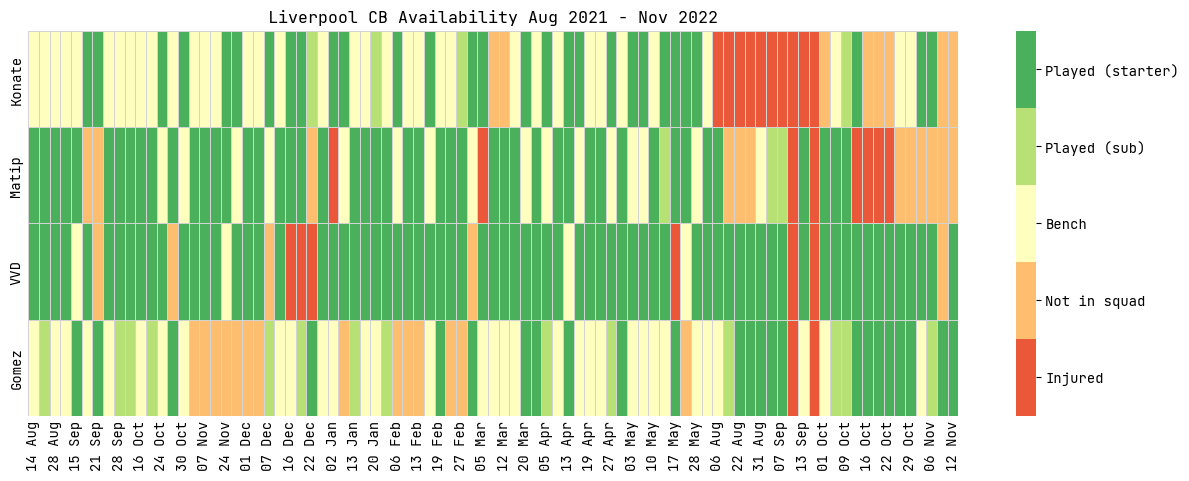

In [22]:
import matplotlib
matplotlib.rcParams['font.family'] = 'JetBrains Mono'

fig,ax = plt.subplots(figsize=(15,5))
availability_levels = availability_df
num_levels = len(availability_levels_map)
plot = sns.heatmap(availability_df, ax=ax, cmap=sns.color_palette("RdYlGn",num_levels),linewidths=0.5, linecolor='lightgray')
colorbar = plot.collections[0].colorbar
total_bar_height = colorbar.vmax - colorbar.vmin 
lvl_bar_height = total_bar_height/num_levels


colorbar.set_ticks([colorbar.vmin + (lvl_bar_height * (0.5 + i)) for i in range(num_levels)])
colorbar.set_ticklabels([*availability_levels_map.keys()])

axs_fmtd = [pd.to_datetime(l.get_text()).date().strftime("%d %b") for l in ax.get_xticklabels()]
_ = ax.set_xticklabels(axs_fmtd)
_ = ax.set_xlabel("")
_ = ax.set_title("Liverpool CB Availability Aug 2021 - Nov 2022")
_ = ax.tick_params(length=0)
# _ = plt.gcf().text(0.8, 0, "ismailmo.com", fontsize=12, fontdict={'color':  'blue'} )

20-21 Season (Injury Disaster lol)

In [23]:
lpool_url_2020 =  get_prem_club_list()['Liverpool FC'].replace('2022', '2020')
lpool_players_2020 = get_player_list(lpool_url_2020)
lpool_cbs_2020 = ['Virgil van Dijk','Joe Gomez','Joel Matip']
availability_dfs_2020 = [get_player_availability("https://www.transfermarkt.com" + lpool_players_2020[player_name]+ "/saison/2020/plus/1") for player_name in lpool_cbs_2020]

#get liverpool fixtures
fix_res =requests.get("https://www.transfermarkt.com/liverpool-fc/spielplandatum/verein/31/saison_id/2020/wettbewerb_id//datum_von/0000-00-00/datum_bis/0000-00-00/day/0/plus/1", headers=headers)
fix_df = pd.read_html(fix_res.text)
match_fix = fix_df[1]
match_fix['Date'] = pd.to_datetime(match_fix['Date'].apply(lambda x:str(x).split('. ')[-1]), errors='coerce', dayfirst=True)
match_fix = match_fix.dropna(subset='Date').reset_index(drop=True)
match_fix.set_index('Date', inplace=True)

lpool_avail_2020 = match_fix.merge(pd.concat(availability_dfs_2020).T, how='left',left_index=True, right_index=True).sort_index()
lpool_avail_2020 = lpool_avail_2020[['virgil-van-dijk', 'joe-gomez',
       'joel-matip']].T

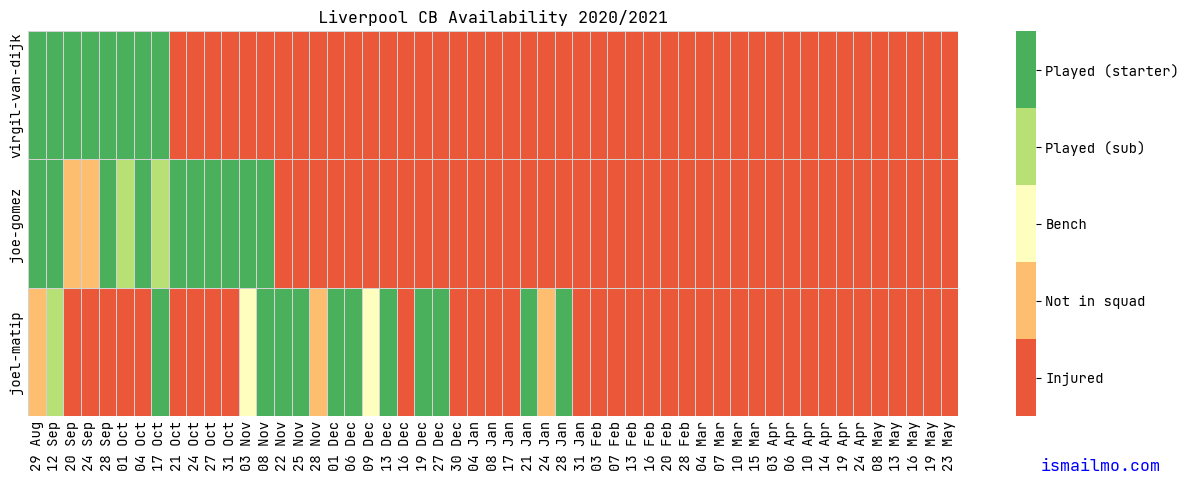

In [24]:
fig,ax = plt.subplots(figsize=(15,5))
availability_levels = lpool_avail_2020
num_levels = len(availability_levels_map)
plot = sns.heatmap(lpool_avail_2020, ax=ax, cmap=sns.color_palette("RdYlGn",num_levels),linewidths=0.5, linecolor='lightgray')
colorbar = plot.collections[0].colorbar
total_bar_height = colorbar.vmax - colorbar.vmin 
lvl_bar_height = total_bar_height/num_levels


colorbar.set_ticks([colorbar.vmin + (lvl_bar_height * (0.5 + i)) for i in range(num_levels)])
colorbar.set_ticklabels([*availability_levels_map.keys()])

axs_fmtd = [pd.to_datetime(l.get_text()).date().strftime("%d %b") for l in ax.get_xticklabels()]
_ = ax.set_xticklabels(axs_fmtd)
_ = ax.set_xlabel("")
_ = ax.set_title("Liverpool CB Availability 2020/2021")
_ = ax.tick_params(length=0)
_ = plt.gcf().text(0.8, 0, "ismailmo.com", fontsize=12, fontdict={'color':  'blue'} )

## Adding Results

In [25]:
from typing import Literal
def get_result_outcome(row:pd.Series)->Literal['W']| Literal['L']| Literal['D'] | None:
    is_home_team = 'liverpool' in str(row['Home team.1']).lower()
    result = str(row['Result']).split(" ")[0]
    try:
        home_goals = int(str(result).split(":")[0])
        away_goals = int(str(result).split(":")[1])
    except ValueError:
        return None
    if home_goals == away_goals:
        return 'D'
    if is_home_team:
        if home_goals > away_goals:
            return 'W'
        return 'L'
    if not is_home_team:
        if home_goals < away_goals:
            return 'W'
        return 'L'
    return None

In [26]:
match_fix['Win'] = match_fix.apply(get_result_outcome, axis=1)
fix_df = pd.DataFrame(match_fix['Win'].map({"W":2, "D":"1", "L":0}))
fix_df['Win'] = pd.to_numeric(fix_df['Win'])
fix_df = fix_df.T

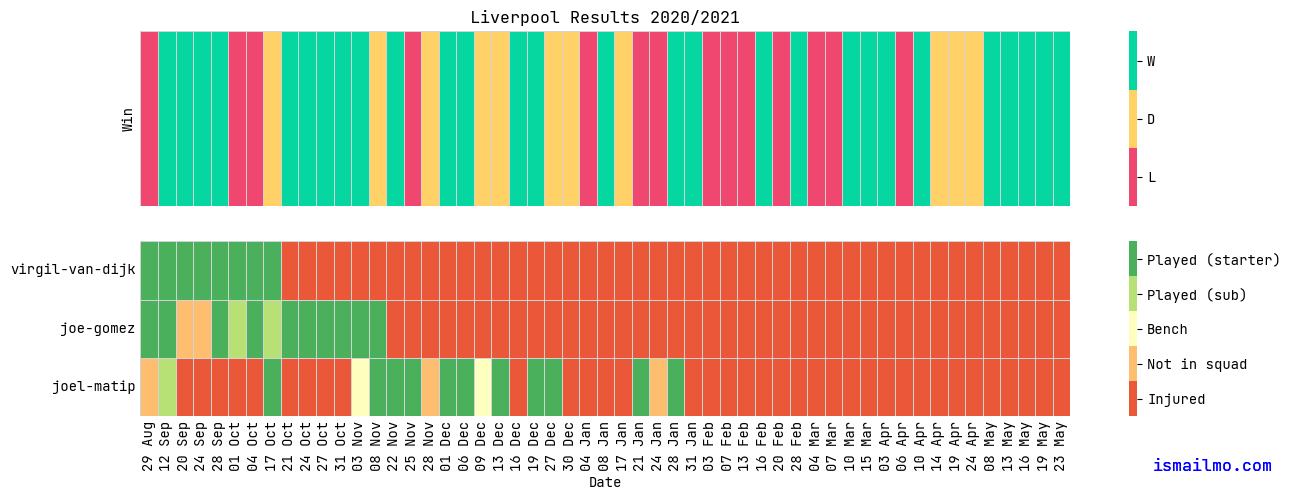

In [27]:
fig,(ax1, ax2) = plt.subplots(nrows=2, figsize=(15,5), sharex=True)
results_map = {"L":0, "D":"1", "W":2 }
num_levels = len(results_map.keys())
plot = sns.heatmap(fix_df, ax=ax1, cmap=["#EF476F","#FFD166", "#06D6A0"],linewidths=0.5, linecolor='lightgray')
colorbar = plot.collections[0].colorbar
total_bar_height = colorbar.vmax - colorbar.vmin 
lvl_bar_height = total_bar_height/num_levels


colorbar.set_ticks([colorbar.vmin + (lvl_bar_height * (0.5 + i)) for i in range(num_levels)])
colorbar.set_ticklabels([*results_map.keys()])

axs_fmtd = [pd.to_datetime(l.get_text()).date().strftime("%d %b") for l in ax1.get_xticklabels()]
_ = ax1.set_xticklabels(axs_fmtd)
_ = ax1.set_xlabel("")
_ = ax1.set_title("Liverpool Results 2020/2021")
_ = ax1.tick_params(length=0)
_ = plt.gcf().text(0.8, 0, "ismailmo.com", fontsize=12, fontdict={'color':  'blue'} )

availability_levels = lpool_avail_2020
num_levels = len(availability_levels_map)
plot = sns.heatmap(lpool_avail_2020, ax=ax2, cmap=sns.color_palette("RdYlGn",num_levels),linewidths=0.5, linecolor='lightgray')
colorbar = plot.collections[0].colorbar
total_bar_height = colorbar.vmax - colorbar.vmin 
lvl_bar_height = total_bar_height/num_levels


colorbar.set_ticks([colorbar.vmin + (lvl_bar_height * (0.5 + i)) for i in range(num_levels)])
colorbar.set_ticklabels([*availability_levels_map.keys()])

axs_fmtd = [pd.to_datetime(l.get_text()).date().strftime("%d %b") for l in ax2.get_xticklabels()]
_ = ax2.set_xticklabels(axs_fmtd)
# _ = ax2.set_xlabel("")
# _ = ax2.set_title("Liverpool CB Availability 2020/2021")
_ = ax2.tick_params(length=0)
_ = plt.gcf().text(0.8, 0, "ismailmo.com", fontsize=12, fontdict={'color':  'blue'} )

# Repeat for 2021-2022

In [28]:
lpool_url = get_prem_club_list()['Liverpool FC']
lpool_players = get_player_list(lpool_url)

matip_url = "https://www.transfermarkt.com" + lpool_players['Joel Matip'] 
konate_url = "https://www.transfermarkt.com" + lpool_players['Ibrahima Konaté']
gomez_url = "https://www.transfermarkt.com" + lpool_players['Joe Gomez']
vvd_url = "https://www.transfermarkt.com" + lpool_players['Virgil van Dijk']

matip_avail_df = pd.concat([get_player_availability(matip_url+ "/saison/2021/plus/1"),get_player_availability(matip_url+ "/saison/2022/plus/1")], axis=1)
konate_avail_df = pd.concat([get_player_availability(konate_url+ "/saison/2021/plus/1"),get_player_availability(konate_url+ "/saison/2022/plus/1")], axis=1)
gomez_avail_df = pd.concat([get_player_availability(gomez_url+ "/saison/2021/plus/1"),get_player_availability(gomez_url+ "/saison/2022/plus/1")], axis=1)
vvd_avail_df = pd.concat([get_player_availability(vvd_url+ "/saison/2021/plus/1"),get_player_availability(vvd_url+ "/saison/2022/plus/1")], axis=1)

availability_df = pd.concat([konate_avail_df, matip_avail_df, vvd_avail_df, gomez_avail_df])
availability_df.dropna(axis=1, inplace=True)
availability_df.rename({'ibrahima-konate':'Konate', 'joel-matip':'Matip', 'virgil-van-dijk':'VVD', 'joe-gomez':'Gomez'}, inplace=True)
availability_df.columns = pd.to_datetime(availability_df.columns)

In [29]:
availability_df

Date,2021-08-14,2021-08-21,2021-08-28,2021-09-12,2021-09-15,2021-09-18,2021-09-21,2021-09-25,2021-09-28,2021-10-03,...,2022-10-12,2022-10-16,2022-10-19,2022-10-22,2022-10-26,2022-10-29,2022-11-01,2022-11-06,2022-11-09,2022-11-12
Konate,2,2,2,2,2,4,4,2,2,2,...,4,1,1,1,2,2,4,4,1,1
Matip,4,4,4,4,4,1,1,4,4,4,...,0,0,0,0,1,1,1,1,1,1
VVD,4,4,4,4,2,4,1,4,4,4,...,4,4,4,4,4,4,4,4,1,4
Gomez,2,3,2,2,4,2,4,2,3,3,...,4,4,4,4,4,4,2,3,4,4


In [30]:
#get liverpool fixtures
def get_lpool_fix(year:str):
    fix_res =requests.get(f"https://www.transfermarkt.com/liverpool-fc/spielplandatum/verein/31/saison_id/{year}/wettbewerb_id//datum_von/0000-00-00/datum_bis/0000-00-00/day/0/plus/1", headers=headers)
    fix_df = pd.read_html(fix_res.text)
    match_fix = fix_df[1]
    match_fix['Date'] = pd.to_datetime(match_fix['Date'].apply(lambda x:str(x).split('. ')[-1]), errors='coerce', dayfirst=True)
    match_fix = match_fix.dropna(subset='Date').reset_index(drop=True)
    match_fix.set_index('Date', inplace=True)
    match_fix.dropna(how="all", axis=1, inplace=True)
    #drop matches where we have no result
    match_fix['Win'] = match_fix.apply(get_result_outcome, axis=1)
    match_fix.dropna(subset='Win', inplace=True)
    return match_fix

In [31]:
match_fix_21 = get_lpool_fix('2021')
match_fix_22 = get_lpool_fix('2022')

In [32]:
matches_21_22 = pd.concat([match_fix_22, match_fix_21])

In [33]:

lpool_avail_2021_22 = matches_21_22.merge(availability_df.T, how='left',left_index=True, right_index=True).sort_index()
lpool_avail_2021_22 = lpool_avail_2021_22[['Win', 'Konate', 'Matip', 'VVD',
       'Gomez']]

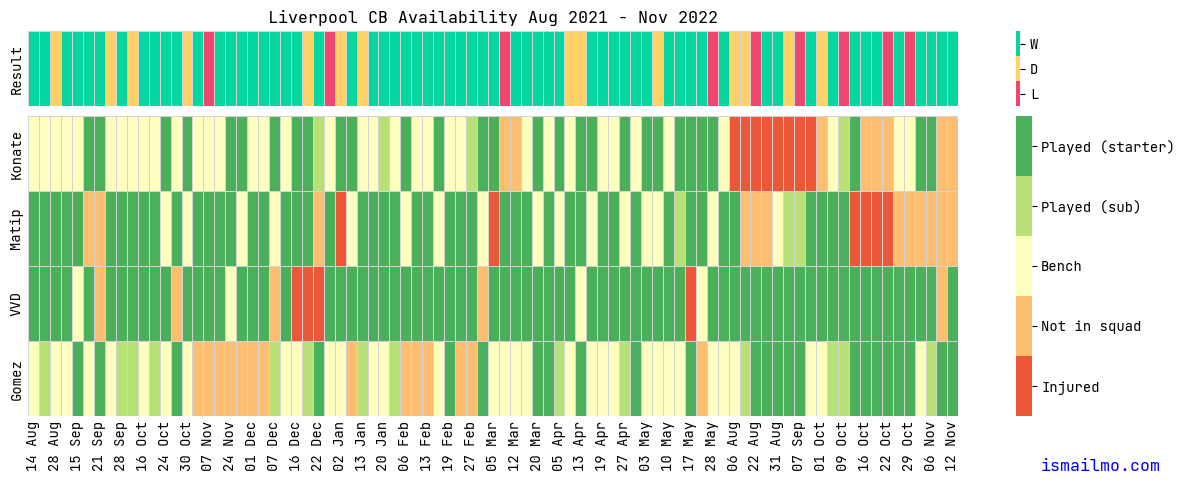

In [34]:
import matplotlib
matplotlib.rcParams['font.family'] = 'JetBrains Mono'
fig,(ax1, ax) = plt.subplots(nrows=2, sharex=True, figsize=(15,5), height_ratios=[1, 4])
results_map = {"L":0, "D":"1", "W":2 }
fix_df = pd.DataFrame(lpool_avail_2021_22['Win'].map(results_map))
fix_df['Result'] = pd.to_numeric(fix_df['Win'])
fix_df.drop('Win', axis=1, inplace=True)

num_levels = len(results_map.keys())
plot = sns.heatmap(fix_df.T, ax=ax1, cmap=["#EF476F","#FFD166", "#06D6A0"],linewidths=0.5, linecolor='lightgray')
colorbar = plot.collections[0].colorbar
total_bar_height = colorbar.vmax - colorbar.vmin 
lvl_bar_height = total_bar_height/num_levels


colorbar.set_ticks([colorbar.vmin + (lvl_bar_height * (0.5 + i)) for i in range(num_levels)])
colorbar.set_ticklabels([*results_map.keys()])

axs_fmtd = [pd.to_datetime(l.get_text()).date().strftime("%d %b") for l in ax1.get_xticklabels()]
_ = ax1.set_xticklabels(axs_fmtd)
_ = ax1.set_xlabel("")
_ = ax1.tick_params(length=0)
_ = ax1.set_title("Liverpool CB Availability Aug 2021 - Nov 2022")

availability_df = lpool_avail_2021_22[['Konate', 'Matip', 'VVD',
       'Gomez']]
num_levels = len(availability_levels_map)
plot = sns.heatmap(availability_df.T, ax=ax, cmap=sns.color_palette("RdYlGn",num_levels),linewidths=0.5, linecolor='lightgray')
colorbar = plot.collections[0].colorbar
total_bar_height = colorbar.vmax - colorbar.vmin 
lvl_bar_height = total_bar_height/num_levels


colorbar.set_ticks([colorbar.vmin + (lvl_bar_height * (0.5 + i)) for i in range(num_levels)])
colorbar.set_ticklabels([*availability_levels_map.keys()])

axs_fmtd = [pd.to_datetime(l.get_text()).date().strftime("%d %b") for l in ax.get_xticklabels()]
_ = ax.set_xticklabels(axs_fmtd)
_ = ax.set_xlabel("")
_ = ax.tick_params(length=0)

plt.subplots_adjust(hspace=0.05)
_ = plt.gcf().text(0.8, 0, "ismailmo.com", fontsize=12, fontdict={'color':  'blue'} )

Colorblind friendly

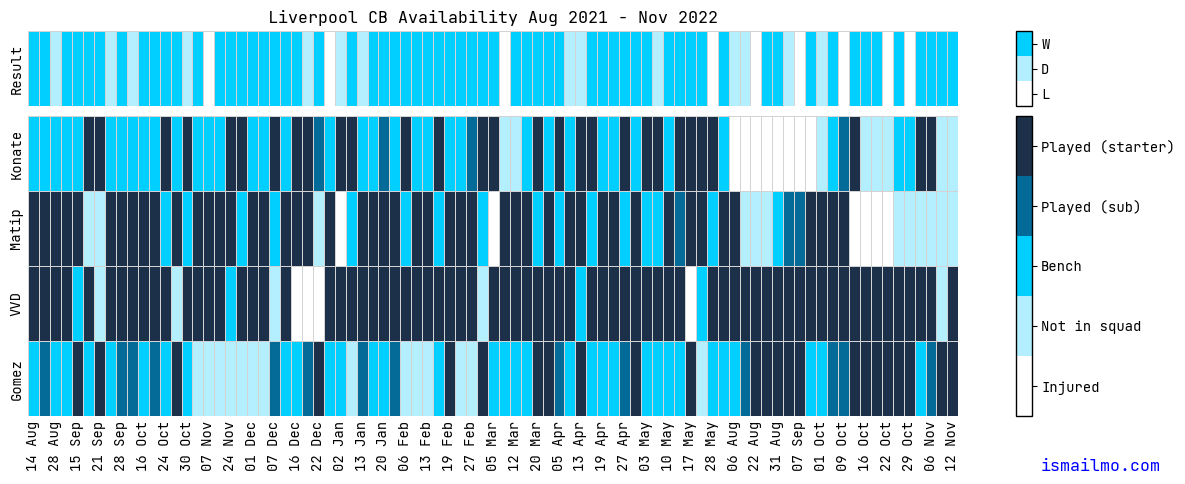

In [35]:

# https://gist.github.com/thriveth/8560036
CB_color_cycle = ["#FFFFFF",
"#B3EFFF",
"#00CFFF",
"#046B99",
"#1C304A",
"#000000",
]

fig,(ax1, ax) = plt.subplots(nrows=2, sharex=True, figsize=(15,5), height_ratios=[1, 4])
results_map = {"L":0, "D":"1", "W":2 }
fix_df = pd.DataFrame(lpool_avail_2021_22['Win'].map(results_map))
fix_df['Result'] = pd.to_numeric(fix_df['Win'])
fix_df.drop('Win', axis=1, inplace=True)

num_levels = len(results_map.keys())
plot = sns.heatmap(fix_df.T, ax=ax1, cmap=CB_color_cycle[0:3],linewidths=0.5, linecolor='lightgray',cbar_kws={'aspect':5})
colorbar = plot.collections[0].colorbar
total_bar_height = colorbar.vmax - colorbar.vmin 
lvl_bar_height = total_bar_height/num_levels


colorbar.set_ticks([colorbar.vmin + (lvl_bar_height * (0.5 + i)) for i in range(num_levels)])
colorbar.set_ticklabels([*results_map.keys()])
colorbar.drawedges=True
colorbar.outline.set_linewidth(1)

axs_fmtd = [pd.to_datetime(l.get_text()).date().strftime("%d %b") for l in ax1.get_xticklabels()]
_ = ax1.set_xticklabels(axs_fmtd)
_ = ax1.set_xlabel("")
_ = ax1.tick_params(length=0)
_ = ax1.set_title("Liverpool CB Availability Aug 2021 - Nov 2022")

availability_df = lpool_avail_2021_22[['Konate', 'Matip', 'VVD',
       'Gomez']]
num_levels = len(availability_levels_map)
plot = sns.heatmap(availability_df.T, ax=ax, cmap=CB_color_cycle[0:num_levels],linewidths=0.5, linecolor='lightgray')
colorbar = plot.collections[0].colorbar
total_bar_height = colorbar.vmax - colorbar.vmin 
lvl_bar_height = total_bar_height/num_levels

colorbar.set_ticks([colorbar.vmin + (lvl_bar_height * (0.5 + i)) for i in range(num_levels)])
colorbar.set_ticklabels([*availability_levels_map.keys()])
colorbar.drawedges=True
colorbar.outline.set_linewidth(1)

axs_fmtd = [pd.to_datetime(l.get_text()).date().strftime("%d %b") for l in ax.get_xticklabels()]
_ = ax.set_xticklabels(axs_fmtd)
_ = ax.set_xlabel("")
_ = ax.tick_params(length=0)

plt.subplots_adjust(hspace=0.05)
_ = plt.gcf().text(0.8, 0, "ismailmo.com", fontsize=12, fontdict={'color':  'blue'} )

Refactor get_player_availability so it's more flexible with different injury types, and so we can separate out types of games e.g. premier league, efl cup, champions league

In [68]:
get_player_availability(vvd_url+ "/saison/2022/plus/1")

Date,2022-06-03,2022-06-08,2022-06-11,2022-06-14,2022-07-30,2022-08-06,2022-08-15,2022-08-22,2022-08-27,2022-08-31,...,2022-10-12,2022-10-16,2022-10-19,2022-10-22,2022-10-26,2022-10-29,2022-11-01,2022-11-06,2022-11-09,2022-11-12
virgil-van-dijk,4,0,0,0,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,1,4


In [277]:
from enum import Enum

class Competition(Enum):
    PREMIER_LEAGUE = 'GB1'


def get_player_availability(player_url:str, 
    competition:Competition, 
    season:str,
    columns:Literal['Matchday'] | Literal['Date']
    ):
    # get name out of url
    player_url = player_url + f"/plus/1?saison={season}&wettbewerb={competition.value}" 
    player_name = player_url.split("https://www.transfermarkt.com/")[1].split("/")[0]
    # stats for injuries are on different page to profile
    player_url = player_url.replace("profil", "leistungsdatendetails")
    headers ={
        "sec-ch-ua": '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
        "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"
    }
    tm_res = requests.get(url = player_url, headers=headers)


    dfs = pd.read_html(tm_res.text)
    match_dfs =[]
    for idx,df in enumerate(dfs):
        if 'Matchday' in df.columns:
            match_dfs.append(df)
    all_matches = pd.concat(match_dfs)

    # remove footer row
    all_matches = all_matches.loc[all_matches.iloc[:,0].apply(lambda x:'Squad' not in str(x))]
    all_matches['Date'] = pd.to_datetime(all_matches['Date'])

    # last column is minutes played
    all_matches['min_played'] = all_matches.iloc[:,16]
    # check if player used as sub
    all_matches['subbed_off'] = all_matches.iloc[:,15]
    all_matches['subbed_on'] = all_matches.iloc[:,14]
    all_matches.dropna(axis=1, how='all', inplace=True)

    all_matches = all_matches.loc[:,['Date', 'Matchday', 'Home team.1','Away team.1', 'Result','min_played','subbed_on', 'subbed_off']]

    def get_availability(row:pd.Series):
        if row['Result'] == "-:-":
            return None
        if row['min_played']>0:
            if row['subbed_on'] is np.nan:
                return "Played (starter)"
            return "Played (sub)"
        if row['subbed_on'] =='on the bench':
            return "Bench"
        if row['subbed_on'] == 'Not in squad':
            return 'Not in squad'
        if 'suspension' in str(row['subbed_on']).lower():
            return 'Suspended'
        
        return 'Injured'
        
    def get_min_played(min_played:str):
        minutes_split = str(min_played).split("'")
        if len(minutes_split)<2:
            return 0
        else:
            return int(minutes_split[0])
    all_matches['min_played'] = all_matches['min_played'].apply(get_min_played)

    # create categories based on subbed on/off, minutes played
    all_matches['availability'] = all_matches.apply(get_availability, axis=1)

    availability_levels = {
                            'Injured':0, 
                            'Not in squad':1,
                            'Bench':2, 
                            'Played (sub)':3,
                            'Played (starter)':4 
                            }
    all_matches['availability_level'] = all_matches['availability'].map(availability_levels)


    availability_df = all_matches.loc[:,[columns,'availability_level']]
    if columns =='Date':
        availability_df['Date'] = availability_df['Date'].apply(lambda x:x.date())
    else:
        availability_df['Matchday'] = pd.to_numeric(availability_df['Matchday'])
    availability_df.sort_values(columns, inplace=True)
    availability_df = availability_df.set_index(columns).transpose()
    availability_df.rename({"availability_level":player_name},axis=0, inplace=True)

    return availability_df

In [138]:
vvd_url = "https://www.transfermarkt.com" + lpool_players['Virgil van Dijk']
competition= Competition.PREMIER_LEAGUE
season = '2022'
columns:Literal['Matchday'] | Literal['Date'] = 'Matchday'
get_player_availability(vvd_url, competition, season, columns)

Matchday,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
virgil-van-dijk,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


In [140]:
laporte_url = "https://www.transfermarkt.com/aymeric-laporte/profil/spieler/176553"

get_player_availability(laporte_url, competition, season, columns)

Matchday,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
aymeric-laporte,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,3.0,2.0,2.0,NaN,4.0,4.0,2.0,4.0


In [146]:
prem_clubs = get_prem_club_list('2021')
prem_clubs.keys()

dict_keys(['Manchester City', 'Liverpool FC', 'Chelsea FC', 'Manchester United', 'Tottenham Hotspur', 'Arsenal FC', 'Leicester City', 'Aston Villa', 'Everton FC', 'Wolverhampton Wanderers', 'West Ham United', 'Brighton & Hove Albion', 'Newcastle United', 'Leeds United', 'Southampton FC', 'Brentford FC', 'Crystal Palace', 'Norwich City', 'Watford FC', 'Burnley FC'])

In [147]:
mancity_url = prem_clubs['Manchester City']
mancity_players = get_player_list(mancity_url)
mancity_players.keys()

dict_keys(['Raheem Sterling', 'John Stones', 'Kyle Walker', 'Kevin De Bruyne', 'Bernardo Silva', 'James McAtee', 'Gabriel Jesus', 'Zack Steffen', 'Nathan Aké', 'Luke Mbete', 'CJ Egan-Riley', 'Claudio Gomes', 'Liam Delap', 'Jack Grealish', 'Rodri', 'Ederson', 'Benjamin Mendy', 'Samuel Edozie', 'Ferran Torres', 'Josh Wilson-Esbrand', 'Oscar Bobb', 'Finley Burns', 'Scott Carson', 'Riyad Mahrez', 'Cole Palmer', 'Yan Couto', 'Rúben Dias', 'Kayky', 'Roméo Lavia', 'Oleksandr Zinchenko', 'Ilkay Gündogan', 'Tommy Doyle', 'Ben Knight', 'Cieran Slicker', 'João Cancelo', 'Fernandinho', 'Phil Foden', 'Aymeric Laporte', 'Philippe Sandler'])

In [197]:
from typing import List, Tuple

def get_player_list_by_position(team_url:str)->Dict[str,List[Tuple[str,str,str]]]:
    """
    if team_url doesn't have "saison" parameter, the current season's players 
    will be returned.
    get profile links of players at team_name grouped by position
    returns {'player_name':'player_url'}
    """
    headers ={
        "sec-ch-ua": '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
        "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36"
        }
    team_res = requests.get(url ="https://www.transfermarkt.com" + team_url, headers=headers)
    soup = bs4.BeautifulSoup(team_res.text)
    player_elements = soup.select(":nth-child(2 of tr .posrela tr td) a")[::2]
    positions = [el.text for el in soup.select(":nth-child(2 of tr .posrela tr)")]
    player_names = [player.contents[0]for player in player_elements]
    player_links = [player['href'] for player in player_elements]
    zipped_player_link_pos = list(zip(player_names,player_links, positions))
    positions = {pos[2] for pos in zipped_player_link_pos}
    player_by_position = {}

    for position in positions:
        player_by_position[position] = [player for player in zipped_player_link_pos if player[2]==position]
    
    return player_by_position

In [303]:
def get_position_availability(team_players: Dict[str, List[Tuple[str, str, str]]], seasons:List[str], position:str):
    team_cb_urls= ["https://www.transfermarkt.com" + player[1] for player in team_players[position]]

    all_seasons_dfs =[]
    for season in seasons:
        curr_season_dfs = []

        for cb in team_cb_urls:
            try:
                curr_season_dfs.append(get_player_availability(cb,Competition.PREMIER_LEAGUE, season, columns='Date'))
            except:
                print(cb + " failed for season " + season)
        # join all player rows
        team_df = pd.DataFrame()
        for df in curr_season_dfs:
            try:
                team_df = pd.concat([team_df, df])
            except:
                continue
        all_seasons_dfs.append(team_df)

    # join all season columns
    return pd.concat(all_seasons_dfs, axis=1)

In [243]:
def plot_availability_heatmap(availability_df:pd.DataFrame, 
axis, 
availability_levels_map = {
    'Injured':0, 
    'Not in squad':1,
    'Bench':2, 
    'Played (sub)':3,
    'Played (starter)':4 
    }):
    num_levels = len(availability_levels_map.keys())    
    plot = sns.heatmap(availability_df, ax=axis, cmap=sns.color_palette("RdYlGn",num_levels),linewidths=0.5, linecolor='lightgray')
    
    colorbar = plot.collections[0].colorbar
    total_bar_height = colorbar.vmax - colorbar.vmin 
    lvl_bar_height = total_bar_height/num_levels

    colorbar.set_ticks([colorbar.vmin + (lvl_bar_height * (0.5 + i)) for i in range(num_levels)])
    colorbar.set_ticklabels([*availability_levels_map.keys()])
    

In [381]:
def get_team_fixtures(team_url:str, year:str, competition:Competition):
    
    fixture_url = team_url.replace("startseite", "spielplandatum")
    fixture_url = fixture_url.split("saison_id")[0]+ f"/plus/1?saison_id={year}&wettbewerb_id={competition.value}"
    fix_res =requests.get("https://www.transfermarkt.com"+fixture_url, headers=headers)
    fix_df = pd.read_html(fix_res.text)
    match_fix = fix_df[1]
    match_fix['Date'] = pd.to_datetime(match_fix['Date'].apply(lambda x:str(x).split('. ')[-1]), errors='coerce', dayfirst=True)
    match_fix = match_fix.dropna(subset='Date').reset_index(drop=True)
    match_fix.set_index('Date', inplace=True)
    match_fix.dropna(how="all", axis=1, inplace=True)
    #drop matches where we have no result
    match_fix['Win'] = match_fix.apply(get_result_outcome, axis=1)
    match_fix.dropna(subset='Win', inplace=True)
    return match_fix

In [352]:
prem_clubs

{'Manchester City': '/manchester-city/startseite/verein/281/saison_id/2021',
 'Liverpool FC': '/fc-liverpool/startseite/verein/31/saison_id/2021',
 'Chelsea FC': '/fc-chelsea/startseite/verein/631/saison_id/2021',
 'Manchester United': '/manchester-united/startseite/verein/985/saison_id/2021',
 'Tottenham Hotspur': '/tottenham-hotspur/startseite/verein/148/saison_id/2021',
 'Arsenal FC': '/fc-arsenal/startseite/verein/11/saison_id/2021',
 'Leicester City': '/leicester-city/startseite/verein/1003/saison_id/2021',
 'Aston Villa': '/aston-villa/startseite/verein/405/saison_id/2021',
 'Everton FC': '/fc-everton/startseite/verein/29/saison_id/2021',
 'Wolverhampton Wanderers': '/wolverhampton-wanderers/startseite/verein/543/saison_id/2021',
 'West Ham United': '/west-ham-united/startseite/verein/379/saison_id/2021',
 'Brighton & Hove Albion': '/brighton-amp-hove-albion/startseite/verein/1237/saison_id/2021',
 'Newcastle United': '/newcastle-united/startseite/verein/762/saison_id/2021',
 'Le

In [295]:
[*prem_clubs.keys()][0:6]

['Manchester City',
 'Liverpool FC',
 'Chelsea FC',
 'Manchester United',
 'Tottenham Hotspur',
 'Arsenal FC']

In [326]:
team_avail_dfs ={}

for team_name in [*prem_clubs.keys()][0:6]:
    seasons = ['2021', '2022']
    position = 'Centre-Back'
    team_url = prem_clubs[team_name]
    team_players = get_player_list_by_position(team_url)

    team_avail_dfs[team_name]=get_position_availability(team_players, seasons, position)

https://www.transfermarkt.com/philippe-sandler/profil/spieler/340460 failed for season 2021
https://www.transfermarkt.com/finley-burns/profil/spieler/581681 failed for season 2021
https://www.transfermarkt.com/philippe-sandler/profil/spieler/340460 failed for season 2022
https://www.transfermarkt.com/cj-egan-riley/profil/spieler/581669 failed for season 2022
https://www.transfermarkt.com/finley-burns/profil/spieler/581681 failed for season 2022
https://www.transfermarkt.com/sepp-van-den-berg/profil/spieler/541231 failed for season 2021
https://www.transfermarkt.com/ben-davies/profil/spieler/257097 failed for season 2021
https://www.transfermarkt.com/billy-koumetio/profil/spieler/696324 failed for season 2021
https://www.transfermarkt.com/rhys-williams/profil/spieler/503679 failed for season 2022
https://www.transfermarkt.com/ben-davies/profil/spieler/257097 failed for season 2022
https://www.transfermarkt.com/billy-koumetio/profil/spieler/696324 failed for season 2022
https://www.trans

In [411]:
chelsea_21_prem_fix = get_team_fixtures(prem_clubs['Chelsea FC'], '2021', Competition.PREMIER_LEAGUE)
chelsea_22_prem_fix = get_team_fixtures(prem_clubs['Chelsea FC'], '2022', Competition.PREMIER_LEAGUE)
chelsea_21_22_prem_fix = pd.concat([chelsea_21_prem_fix, chelsea_22_prem_fix])
prem_games = team_avail_dfs['Chelsea FC'].iloc[[0,1,2,4], :].dropna(how="all", axis=1).T.merge(chelsea_21_22_prem_fix,left_index=True, right_index=True)
prem_games.iloc[:,0:4]

,antonio-rudiger,andreas-christensen,trevoh-chalobah,thiago-silva
Date,,,,
2021-08-14,4.0,4.0,4.0,2.0
2021-08-22,4.0,4.0,2.0,2.0
2021-08-28,4.0,4.0,3.0,3.0
2021-09-11,4.0,2.0,4.0,4.0
2021-09-19,4.0,4.0,2.0,4.0
2021-09-25,4.0,4.0,2.0,3.0
2021-10-02,4.0,2.0,4.0,4.0
2021-10-16,1.0,4.0,4.0,1.0
2021-10-23,4.0,2.0,4.0,4.0
